In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [11]:
# data transformation and augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x]) 
                  for x in ['train', 'val']}

data_loaders = {x: torch.utils.data.DataLoader(dataset=image_datasets[x], 
                                               batch_size=4, 
                                               shuffle=True, 
                                               num_workers=4) 
                for x in ['train', 'val']}

data_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

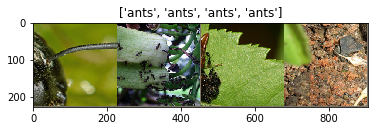

In [25]:
# visualize a few images
def imshow(inp, title=None):
    
    inp = inp.numpy().transpose(1, 2, 0)
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    inp = std * inp + mean
    
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    
    plt.pause(0.001)

images, labels = next(iter(data_loaders['train']))

out = torchvision.utils.make_grid(images)

imshow(out, [class_names[x] for x in labels])

In [27]:
# train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    